# PROJECT 1 FINDING LANES

Imports needed for the projects

In [3]:
#Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

Helper Functions

In [23]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return
    else:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def DisplayImgs(Imgs,NumImgs):
    """
    Takes Image tuple as input and shows images
    """
    for i in range(0,NumImgs):
        plt.figure(i)
        plt.imshow(Imgs[i])


## Image Processing Pipeline

0. Read all the images and store in a tuple, define constants which you will use
1. Detect White lines on a copy
2. Detect Yellow lines on a copy
3. Do Gaussian,Canny on a copy
4. Add all the three images
5. Find Hough lines on this added image

In [90]:
#1 Reading all images
NumImgs=6
Img1=mpimg.imread('test_images/solidWhiteCurve.jpg')
Img2=mpimg.imread('test_images/solidWhiteRight.jpg')
Img3=mpimg.imread('test_images/solidYellowCurve.jpg')
Img4=mpimg.imread('test_images/solidYellowCurve2.jpg')
Img5=mpimg.imread('test_images/solidYellowLeft.jpg')
Img6=mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
Imgs=[Img1,Img2,Img3,Img4,Img5,Img6]

#Get image sizes. As all images are equal size
ySize=Img1.shape[0]
xSize=Img1.shape[1]
#Define vertices of the triangle for ROI
lBottom=[10,ySize-50]
rBottom=[xSize-10,ySize-50]
lTop=[(xSize/2+40),(ySize/1.65)];
rTop=[xSize/2-40,ySize/1.65];
#vertices=np.array([lBottom,rBottom,lTop,rTop],np.int32)  
vertices = np.array([[lBottom,rBottom,lTop,(xSize/2-40,ySize/1.65)]],np.int32)
#Variables for Gaussian and Canny
GaussKernel=7
EdgeLowThresh=100

#DisplayImgs(Imgs,NumImgs)

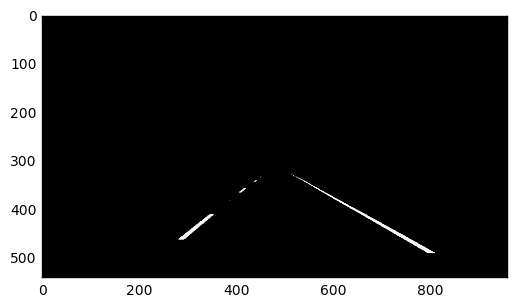

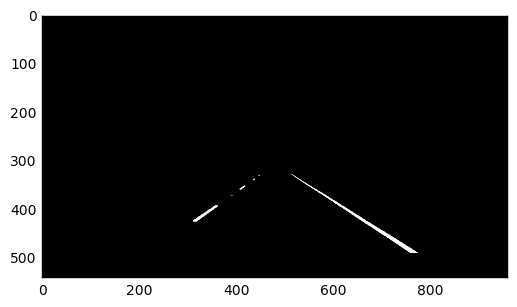

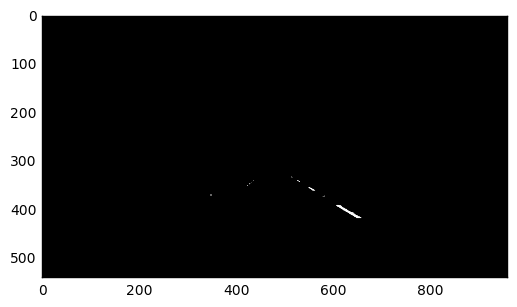

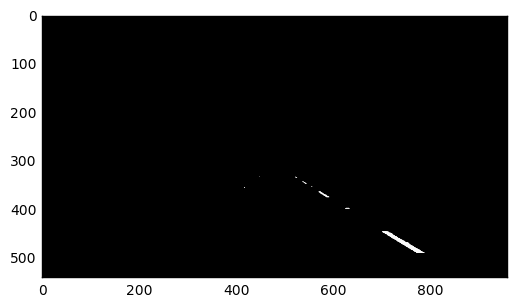

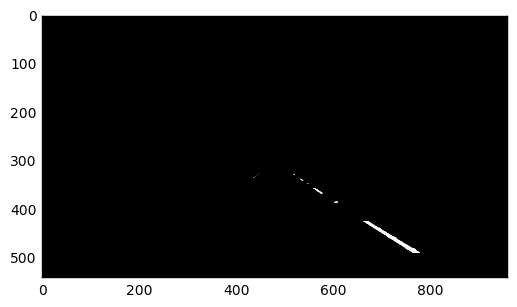

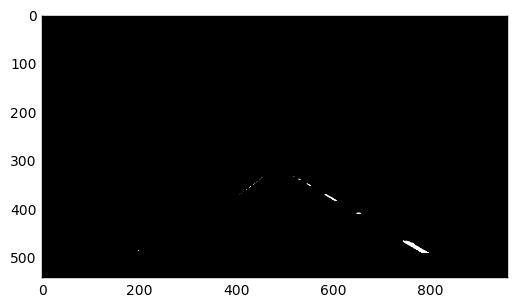

In [101]:
#2 Detect White lines on a copy of image
def detectWhite(Img):
    #Make a copy of image
    wSelect=np.copy(Img)
    #Apply ROI on image 
    maskedImg=region_of_interest(wSelect,[vertices])
    #Threshold Values for White
    rThresh=175
    gThresh=175
    bThresh=160
    #Bitwise OR to mask pixesl below white threshold
    wThresh=(maskedImg[:,:,0] < rThresh) | (maskedImg[:,:,1] < gThresh) | (maskedImg[:,:,2] < bThresh)
    #Black regions which are below white threshold
    wSelect[wThresh]=[0,0,0]
    wSelect=grayscale(wSelect)     
    return wSelect
wImgs=[]
for i in range(0,NumImages):
    wImgs.append(detectWhite(Imgs[i]))     
    plt.figure(i)
    plt.imshow(wImgs[i],cmap='Greys_r')  


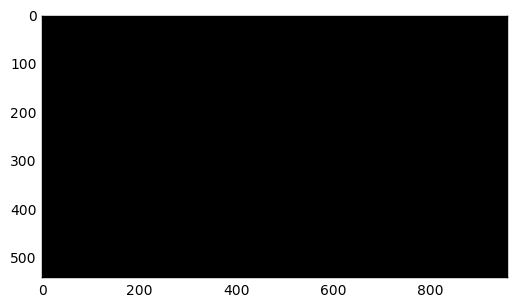

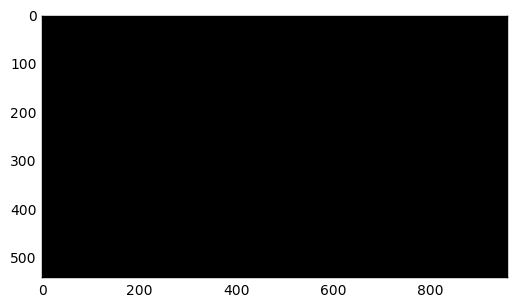

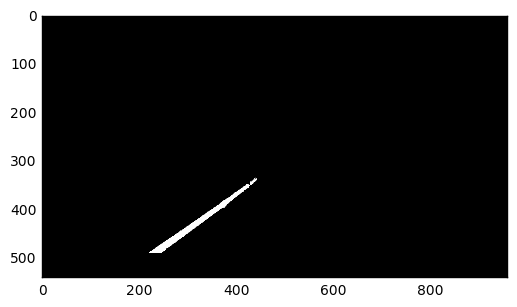

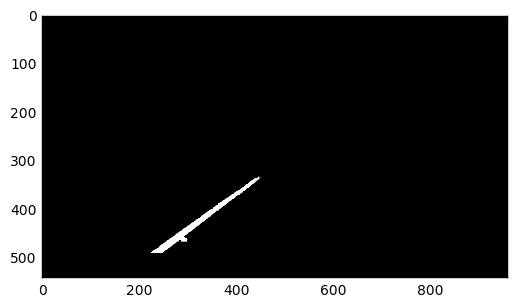

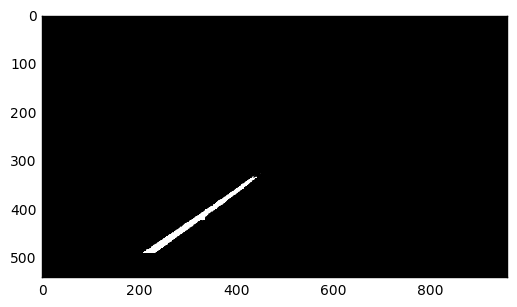

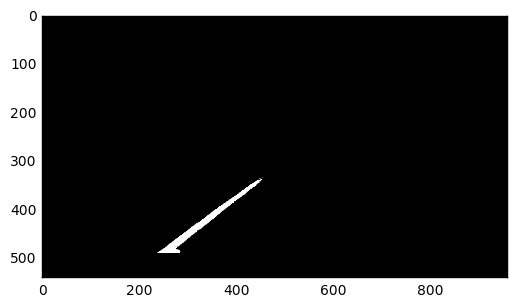

In [131]:
#3 Detect Yellow lines on a copy of image
def detectYellow(Img):    
    #Convert to HSV as it is easier to detect yellow in HSV colorspace
    hsvImg=cv2.cvtColor(Img,cv2.COLOR_RGB2HSV)
    #Apply ROI on image 
    maskedImg=region_of_interest(hsvImg,[vertices])
    #Define yellow thresholds in HSV
    lowYellow  =np.array([5,45,50])
    upperYellow=np.array([50,255,255])
    #Apply Threshold for yellow
    ySelect=cv2.inRange(maskedImg,lowYellow,upperYellow) 
    return ySelect
yImgs=[]
for i in range(0,NumImages):
    yImgs.append(detectYellow(Imgs[i]))
    plt.figure(i)
    plt.imshow(yImgs[i],cmap='Greys_r') 

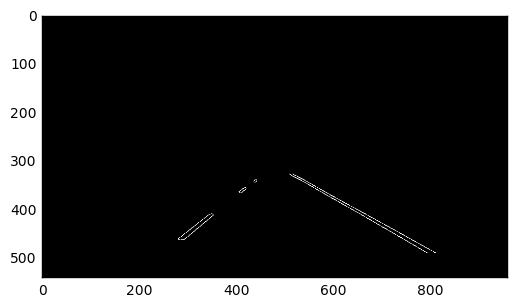

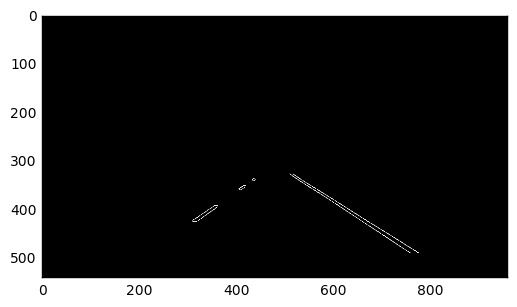

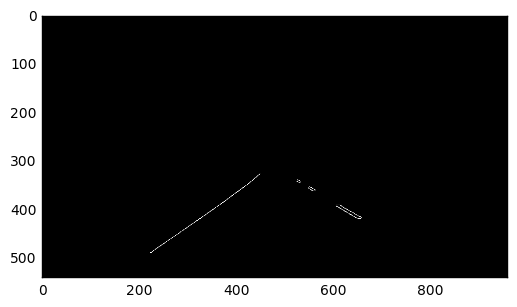

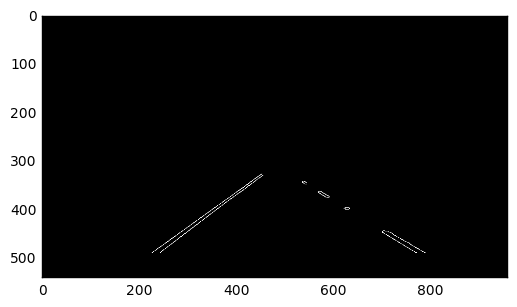

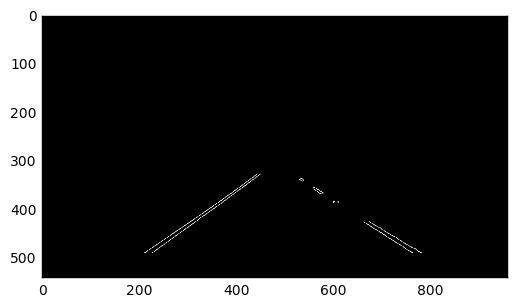

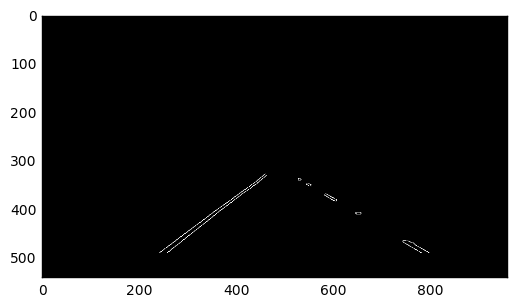

In [133]:
#3 Apply Gaussian and Canny Filter
def GaussCanny(Img):
    #Convert image into Gray
    GrayImg=grayscale(Img)      
    #Blur image with Gaussian Blur
    BlurredImg=gaussian_blur(GrayImg,GaussKernel)
    #Apply Canny Filter for edge detection
    EdgeImg=canny(BlurredImg,EdgeLowThresh,EdgeLowThresh*2)
    #Apply ROI masking to Edge detected image
    maskedImg=region_of_interest(EdgeImg,[vertices])
    return maskedImg
GCImg=[]
for i in range(0,NumImages):
    GCImg.append(GaussCanny(Imgs[i]))
    plt.figure(i)
    plt.imshow(GCImg[i],cmap='Greys_r')    

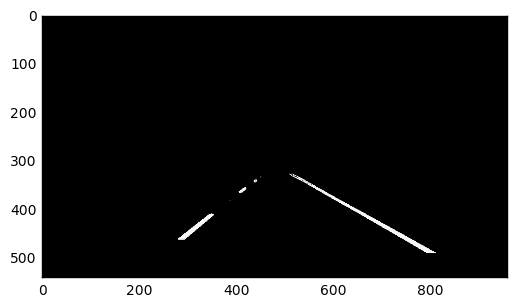

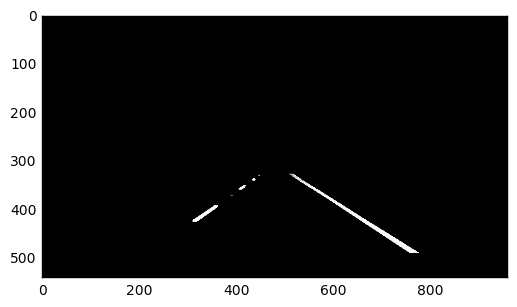

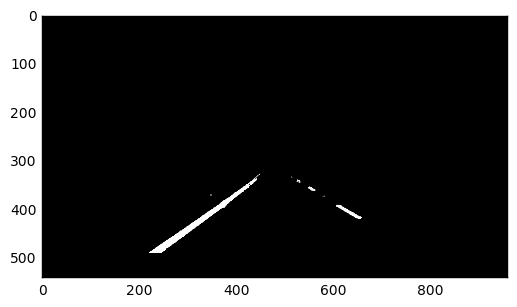

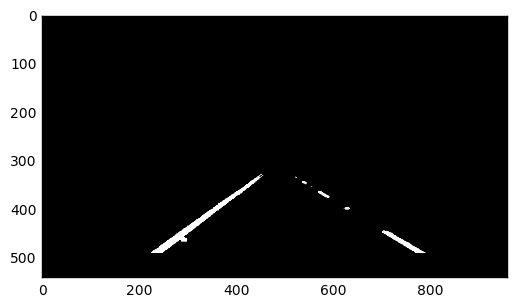

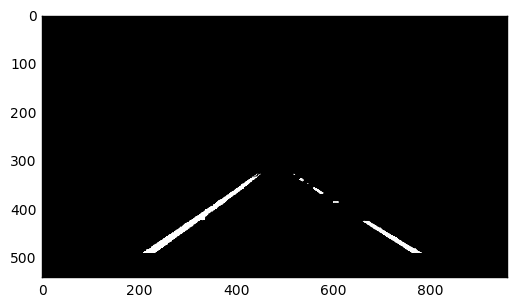

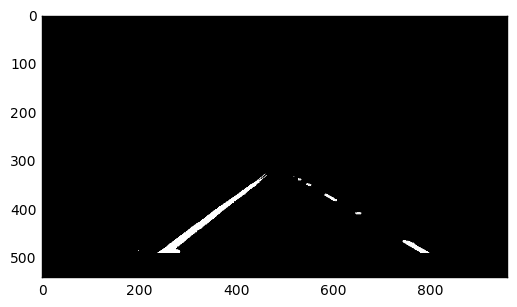

In [134]:
#4. BitWise OR all the images to form a composite
def FuseImgs(wImg,yImg,GCImg):
    wyImg=cv2.bitwise_or(wImg,yImg)
    wyGCImg=cv2.bitwise_or(wyImg,GCImg)    
    return wyGCImg
FusedImgs=[]
for i in range(0,NumImages):
    FusedImgs.append(FuseImgs(wImgs[i],yImgs[i],GCImg[i]))
    plt.figure(i)
    plt.imshow(FusedImgs[i],cmap='Greys_r')  
    

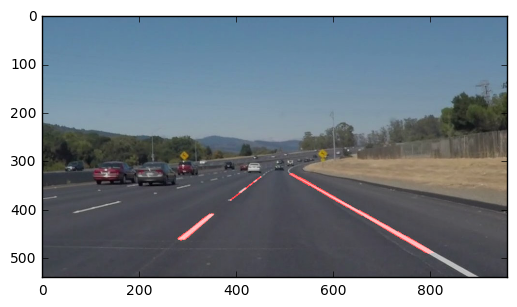

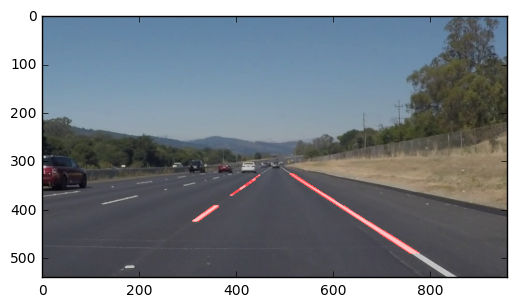

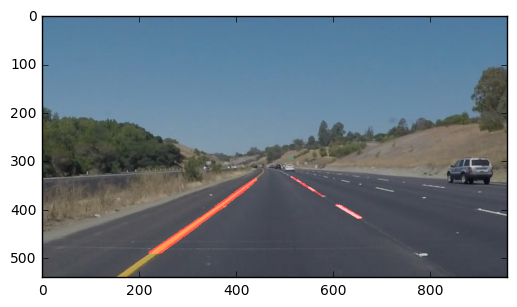

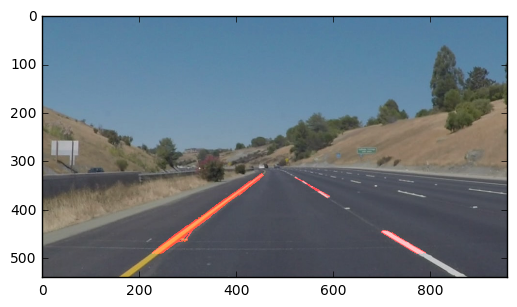

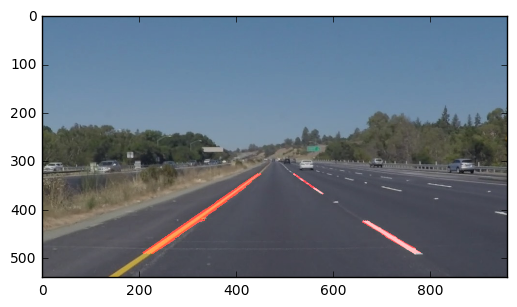

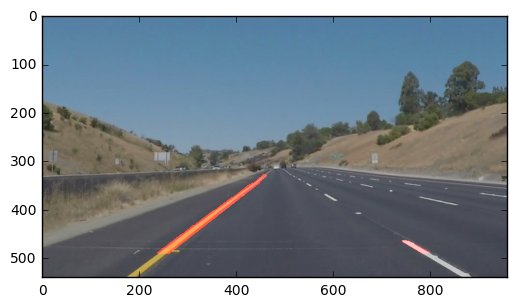

In [136]:
#Parameters for Hough Transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1*(np.pi/180) # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
def FindLane(FusedImg,OrigImg):
    hImg=hough_lines(FusedImg, rho, theta, threshold, min_line_len, max_line_gap)
    finalImg=weighted_img(hImg,OrigImg)
    return finalImg
FinalOpt=[]
for i in range(0,NumImages):
    FinalOpt.append(FindLane(FusedImgs[i],Imgs[i]))
    plt.figure(i)
    plt.imshow(FinalOpt[i])


In [144]:
#Trying it on White Car video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(Img):
    w=detectWhite(Img)
    y=detectYellow(Img)
    GC=GaussCanny(Img)
    Fused=FuseImgs(w,y,GC)
    result=FindLane(Fused,Img)
    return result
whiteOpt='White.mp4'
clip1=VideoFileClip("solidWhiteRight.mp4")
white_clip=clip1.fl_image(process_image)
%time white_clip.write_videofile(whiteOpt, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(whiteOpt))

[MoviePy] >>>> Building video White.mp4
[MoviePy] Writing video White.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 37.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: White.mp4 

Wall time: 6.65 s


In [145]:
#Trying yellow video
yellowOpt='Yellow.mp4'
clip1=VideoFileClip("solidYellowLeft.mp4")
yellow_clip=clip1.fl_image(process_image)
%time yellow_clip.write_videofile(yellowOpt, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellowOpt))

[MoviePy] >>>> Building video Yellow.mp4
[MoviePy] Writing video Yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:19<00:00, 34.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Yellow.mp4 

Wall time: 19.8 s
